# 综合大作业

**第一步：爱奇艺《青春有你2》评论数据爬取**(参考链接：[https://www.iqiyi.com/v_19ryfkiv8w.html#curid=15068699100_9f9bab7e0d1e30c494622af777f4ba39](http://))
* 爬取任意一期正片视频下评论
* 评论条数不少于1000条

**第二步：词频统计并可视化展示**
* 数据预处理：清理清洗评论中特殊字符（如：@#￥%、emoji表情符）,清洗后结果存储为txt文档
* 中文分词：添加新增词（如：青你、奥利给、冲鸭），去除停用词（如：哦、因此、不然、也好、但是）
* 统计top10高频词
* 可视化展示高频词

**第三步：绘制词云**
* 根据词频生成词云
* 可选项-添加背景图片，根据背景图片轮廓生成词云 

**第四步：结合PaddleHub，对评论进行内容审核**


# 需要的配置和准备
* 中文分词需要jieba
* 词云绘制需要wordcloud
* 可视化展示中需要的中文字体
* 网上公开资源中找一个中文停用词表
* 根据分词结果自己制作新增词表
* 准备一张词云背景图（附加项，不做要求，可用hub抠图实现）
* paddlehub配置



In [1]:
!pip install jieba
!pip install wordcloud

Looking in indexes: https://pypi.mirrors.ustc.edu.cn/simple/
Looking in indexes: https://pypi.mirrors.ustc.edu.cn/simple/


In [2]:
# Linux系统默认字体文件路径
# !ls /usr/share/fonts/
# 查看系统可用的ttf格式中文字体
!fc-list :lang=zh | grep ".ttf"

/home/aistudio/.fonts/simhei.ttf: SimHei,黑体:style=Regular,Normal,obyčejné,Standard,Κανονικά,Normaali,Normál,Normale,Standaard,Normalny,Обычный,Normálne,Navadno,Arrunta


In [3]:
# !wget https://mydueros.cdn.bcebos.com/font/simhei.ttf # 下载中文字体
# #创建字体目录fonts
!mkdir .fonts
# # 复制字体文件到该路径
!cp simhei.ttf .fonts/
!rm -rf .cache/matplotlib

mkdir: cannot create directory ‘.fonts’: File exists


In [4]:
#安装模型
!pip install --upgrade paddlehub -i https://pypi.tuna.tsinghua.edu.cn/simple/ 
!hub install porn_detection_lstm==1.1.0

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple/
Requirement already up-to-date: paddlehub in /opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages (1.6.2)
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/sklearn/externals/joblib/externals/cloudpickle/cloudpickle.py:47: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  import imp
2020-04-28 13:38:38,479-INFO: font search path ['/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/ttf', '/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/afm', '/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/pdfcorefonts']
2020-04-28 13:38:38,802-INFO: generated new fontManager
Module porn_detection_lstm-1.1.0 already installed in /home/aistudio/.paddlehub/modules/porn_detection_lstm


In [5]:
from __future__ import print_function
import requests
import json
import re #正则匹配
import time #时间处理模块
import jieba #中文分词
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
from PIL import Image
from collections import Counter
from wordcloud import WordCloud, STOPWORDS  #绘制词云模块, 内带停用词表
import paddlehub as hub

In [6]:
#请求爱奇艺评论接口，返回response信息
def getMovieinfo(url):
    '''
    请求爱奇艺评论接口，返回response信息
    参数  url: 评论的url
    :return: response信息
    '''
    headers = {
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/81.0.4044.122 Safari/537.36'
    }
    try:
        res = requests.get(url, headers=headers)
        if res.status_code == 200:
            return res
        return None
    except:
        return None



In [7]:
#解析json数据，获取评论
def saveMovieInfoToFile(res):
    '''
    解析json数据，获取评论
    参数 arr:存放文本的list
    :return: arr
    '''
    response = res.json()['data']['comments']
    arr = []
    for i in range(len(response)):
        try:
            arr.append(response[i]['content'])
        except KeyError as k:  # 对没有评论的字段做异常处理
            print('该用户未评论')
    return arr

In [8]:
#去除文本中特殊字符
def clear_special_char(title):
    '''
    正则处理特殊字符
    参数 content:原文本
    return: 清除后的文本
    '''
    text = [text for til in title for text in til]
    text2 = []
    NUM = 0
    for i in text:
        text_2 = re.findall(u"[\u4e00-\u9fa5]+|[a-zA-Z]+|[0-9]+", i)
        text2.append(''.join(list(set(text_2))))
        NUM += 1

    with open('./work/aqy.txt', 'w', encoding='utf-8') as f:
        for i in text2:
            f.writelines(i + '\n')

    print(f'共有{NUM}条评论')
    return text2

In [9]:
def fenci(text, stopwords=None, path='./work/'):
    '''
    利用jieba进行分词
    参数 text:需要分词的句子或文本
    return：分词结果
    '''
    # 写入固定词
    userdict = ['虞书欣','kiki','喻言','安琪','刘雨欣','喜爱','王承渲','孔雪儿','vocal'
           '刘令姿','戴佩妮','刘雨昕','安崎','许佳琪','谢可寅','左卓','许杨','赵小棠',
           'lion','shakin','许杨玉琢','青春有你二','段小薇','徐紫茵','魏辰','符雅凝',
           '刘老师','昕雪','X导师','陆柯燃','陈珏','十面埋伏','朱林雨','金子涵',
           '葛鑫怡','承渲','乃万','小棠','马蜀君','范冰冰','陈钰','费沁源','宋昭艺',
           '张楚寒','七穗','练习室','靳阳阳','张娜拉','花腔','出道位','冲鸭','没实力',
           '戴萌','憨憨','陈立农','不喜欢','不给','没当过','汪苏泷','可盐可咸','不那么',
           '不争','不抢', '下一次','不知道','不是','不太适合','不合适','不完美','不能考虑',
           '不考虑','投票','烟嗓','青你','奥利给','太胆怯','太努力','太拼命','太全能',
           '太激动','太感人','太亮眼','太喜欢','太可爱','太谦虚','太开心','太可惜','太好看',
           '太适合','太厉害','太好笑','理想化','太黑','太可怕','冲冲']
    userdict = [i + '\n' for i in userdict]
    with open(path+'userdict.txt', 'w', encoding='utf-8') as f:
        f.writelines(userdict)

    # 导入固定词表
    jieba.load_userdict(path+'userdict.txt')

    # 导入停用词表
    stopwords = stopwords
    text2 = []
    for i in text:
        m = jieba.cut(i)
        text2.append(','.join(list(set(m)-set(stopwords))))   # 对每一个评论进行去除停用词过程
    text2 = ','.join(text2).split(',')

    return text2 


In [10]:
def stopwordslist(path='./work/'):
    '''
    创建停用词表
    参数 file_path:停用词文本路径
    return：停用词list
    '''
    stopwords = set(STOPWORDS)  # 导入WordCloud内置的停止词表

    # 导入公开的中文停用词表
    with open(path+'stopword_user.txt', 'r', encoding='utf-8') as f:
        for i in f.readlines():
            stopwords.add(i.strip('\n'))
    # 加入自制的停用词表
    stoplist = ['哦','因此','不然','也好','但是','真的','哈哈哈','啊啊啊']
    for i in stoplist:
        stopwords.add(i)
    
    return stopwords

In [11]:
def countwords(text, N=10):
    '''
    统计词频
    参数 list counts: 词频统计结果
    return：None
    '''
    text = ','.join(text).split(',')
    counts = Counter(text)
    most_text = dict(counts.most_common(N))
    return most_text
    

In [12]:
def drawcounts(text, N=10):
    '''
    绘制词频统计表
    参数 counts: 词频统计结果 num:绘制topN
    return：none
    '''
    # 设定中文不乱码
    plt.rcParams['font.sans-serif'] = ['simhei']
    plt.rcParams['axes.unicode_minus'] = False

    most_text = countwords(text, N)
    plt.bar(most_text.keys(), most_text.values())
    plt.title(f'爬取评论中出现最多的{N}个词')
    plt.show()
    

In [13]:
def drawcloud(text, stopwords=None):
    '''
    根据词频绘制词云图
    参数 word_f:统计出的词频结果
    return：none
    '''
    # 设定蒙版图

    # 导入抠图模块
    module = hub.Module(name="deeplabv3p_xception65_humanseg")
    # 载入要抠的图片
    result = module.segmentation(data={"image":["work/wordcloud_img.jpg"]})
    img_path = result[0]['processed']

    # 将底色换成白底，使词云图正常展示
    image = Image.open(img_path)  
    img = Image.new('RGB', image.size, (255,255,255))
    img.paste(image, (0, 0), image)
    img = np.array(img)

    # 词云图制作
    wc = WordCloud(font_path="simhei.ttf", background_color='white', scale=2, 
                     min_font_size=10, max_font_size=100, width=400,
                     mask=img, stopwords=stopwords, relative_scaling=0.3)
    wc.generate_from_text(','.join(text))
    
    # 保存
    wc.to_file('pic.png')


In [14]:
def text_detection(text_path, test_text=None):
    '''
    使用hub对评论进行内容分析
    return：分析结果

    '''
    if test_text is None:
        test_text = []
    porn_detection_lstm = hub.Module(name="porn_detection_lstm")
    with open(text_path, 'r', encoding='utf-8') as f:
        lines = f.readlines()
    for i in lines:
        if len(i.replace('\n','').strip()) == 1:
            continue
        else:
            test_text.append(i.replace('\n','').strip())
    input_dict = {"text": test_text}
    results = porn_detection_lstm.detection(data=input_dict,use_gpu=False,batch_size=1)
    # print(results)
    M = N = 0
    print("以下内容可能违规:")
    for index, item in enumerate(results):
        if item['porn_detection_key'] == 'porn':
            N += 1
            print(item['text'], ":", item['porn_probs'])
        M += 1
    plt.bar(['porn','not_porn'],[N,M])
    plt.title('评论内容类别分布占比')
    plt.show()

该用户未评论
该用户未评论
该用户未评论
该用户未评论
该用户未评论
该用户未评论
该用户未评论
该用户未评论
该用户未评论
该用户未评论
该用户未评论
该用户未评论


Building prefix dict from the default dictionary ...
2020-04-28 13:38:59,133-DEBUG: Building prefix dict from the default dictionary ...
Loading model from cache /tmp/jieba.cache
2020-04-28 13:38:59,134-DEBUG: Loading model from cache /tmp/jieba.cache


共有5938条评论


Loading model cost 0.690 seconds.
2020-04-28 13:38:59,823-DEBUG: Loading model cost 0.690 seconds.
Prefix dict has been built successfully.
2020-04-28 13:38:59,825-DEBUG: Prefix dict has been built successfully.


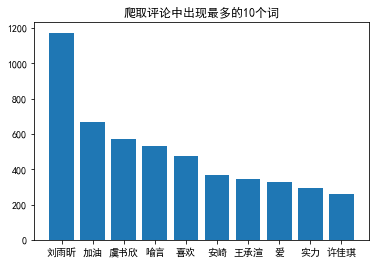

[2020-04-28 13:39:01,009] [    INFO] - Installing deeplabv3p_xception65_humanseg module
[2020-04-28 13:39:01,075] [    INFO] - Module deeplabv3p_xception65_humanseg already installed in /home/aistudio/.paddlehub/modules/deeplabv3p_xception65_humanseg
[2020-04-28 13:39:01,758] [    INFO] - 0 pretrained paramaters loaded by PaddleHub
[2020-04-28 13:39:04,916] [    INFO] - Installing porn_detection_lstm module
[2020-04-28 13:39:04,932] [    INFO] - Module porn_detection_lstm already installed in /home/aistudio/.paddlehub/modules/porn_detection_lstm


以下内容可能违规:
加油哦从一开始我就喜欢上这个可爱幽默的女孩子很勇于挑战自己从性感风的你一直都让我很惊喜你的一点点进步我们都看在眼里小王好棒到可爱风的我怎么这么好看rb : 0.9769
啊啊啊a啊啊 : 0.6487
她就是焦点啊只要有刘雨昕在任何长发性感女生都失去了魅力 : 0.9651
组和A组都很棒B都有起鸡皮说实话觉得想见你 : 0.9732
雨伞觉得刘雨昕和安崎都棒棒的一起走花路吧 : 0.9796
感觉内心好坚定可性感可甜只有我觉得宋昕冉不错吗总是去安慰其他人主题曲出错后基本上没有雷点 : 0.9816
棒棒棒c位出道言言子请色 : 0.8666
王承渲我爱你呀呀呀呀 : 0.793
刘老师换回女装真的超级好看爱了爱了 : 0.6393
雪儿妹妹好美感觉很不一样了呢舞蹈担当雪儿妹妹也可以很帅反正就是棒棒 : 0.998
我觉得每个训练生都很棒加油 : 0.8161
爱死这个女人了棒棒哒刘老师好会设计小动作一定要顺利出道哟 : 0.5791
有人喜欢孙美楠吗 : 0.9396
愉快感觉坤坤很喜欢喻言 : 0.8822
大家都好棒棒呀色 : 0.9819
陆柯燃姐姐爱你啊 : 0.6217
我支持刘雨昕和王乘渲棒棒哒永远支持你俩噢继续加油啊一个帅酷一个可爱 : 0.9905
刘雨昕真的实力强得太可怕了棒棒 : 0.9893
哈哈哈我想看雨昕穿性感点的衣服露个腰也好哈哈哈我莫名生出一种歹念 : 0.9959
看看孔雪儿吧真的很棒的女孩 : 0.7401
符雅凝千万不要淘汰啊啊啊啊啊啊啊啊啊啊啊啊啊啊啊啊啊啊啊啊啊啊啊啊啊啊啊啊啊啊啊啊啊啊啊啊啊啊啊啊啊啊啊啊啊啊啊啊啊啊啊啊啊啊啊啊啊啊啊啊救命流泪 : 0.6012
棒棒刘总带起来了段小薇 : 0.6011
这个妹妹真的很努力很棒啊投投渲吧 : 0.8443
刘雨欣刘雨欣刘雨欣刘雨欣刘雨欣刘雨欣刘雨欣刘雨欣刘雨欣刘雨欣刘雨欣刘雨欣刘雨欣刘雨欣刘雨欣刘雨欣刘雨欣刘雨欣刘雨欣刘雨欣刘雨欣刘雨欣刘雨欣刘雨欣刘雨欣刘雨欣刘雨欣刘雨欣刘雨欣刘雨欣刘雨欣刘雨欣刘雨欣刘雨欣刘雨欣刘雨欣刘雨欣刘雨欣 : 0.5008
不要引战安崎也棒棒的我爱刘雨昕 : 0.9756
色马蜀君你很棒大家会看到你的要一直加油 : 0.8893
这里的小姐姐都好漂亮呀 : 0.8083
卧槽A刘雨昕宝贝太帅了好 : 0.6071
我的眼里只有你

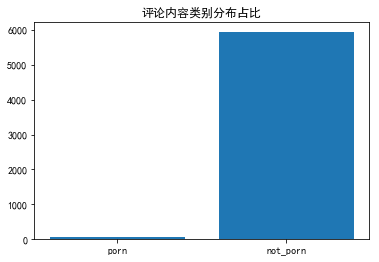

In [15]:
#评论是多分页的，得多次请求爱奇艺的评论接口才能获取多页评论,有些评论含有表情、特殊字符之类的
#num 是页数，一页10条评论，假如爬取1000条评论，设置num=100
if __name__ == "__main__":
    title = []
    for i in range(1, 200):   # 评论获取使用翻页处理，一页30条，观察有200多页
        url = f'https://sns-comment.iqiyi.com/v3/comment/get_comments.action?agent_type=118&business_type=17&content_id=15535228800&page={i}'
        res = getMovieinfo(url)
        get = saveMovieInfoToFile(res)
        title.append(get)
    text = clear_special_char(title)
    # 停用词制作
    stopwords = stopwordslist()
    # 中文分词划分
    text = fenci(text, stopwords=stopwords)
    # 词频统计，并绘制词频图
    drawcounts(text, N=10)
    # 词云图制作
    drawcloud(text, stopwords=stopwords)
    # 对评论内容进行低俗色情分析
    text_detection(text_path='./work/aqy.txt')




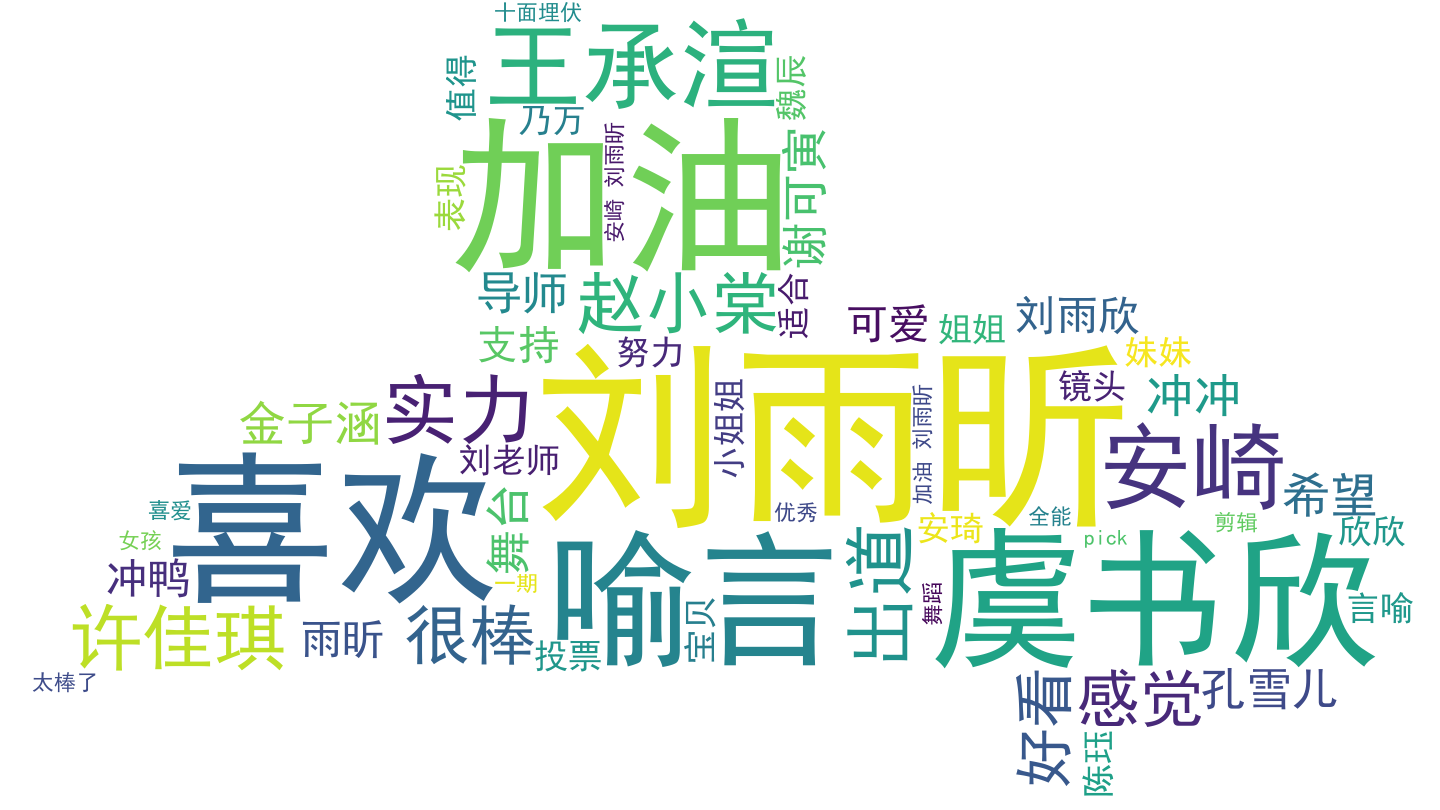

In [16]:
display(Image.open('pic.png')) #显示生成的词云图像